In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
!pip install pytorch_lightning
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 41.5 MB/s eta 0:00:00


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 28
BATCH_SIZE=64
# Define transformations for MNIST dataset
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Load MNIST dataset
dataset = MNIST(root='dataset/', train=True, transform=transform, download=True)

# Get indices for labels 0, 1, 2, 3, 4 for private set
private_indices = [i for i, label in enumerate(dataset.targets) if label in [0, 1, 2, 3, 4]]
public_indices = [i for i, label in enumerate(dataset.targets) if label in [5, 6, 7, 8, 9]]

# Create subsets for private and public
private_set = Subset(dataset, private_indices)
public_set = Subset(dataset, public_indices)

# Create data loaders
private_train_loader = DataLoader(private_set, batch_size=BATCH_SIZE, shuffle=True)
public_train_loader = DataLoader(public_set, batch_size=BATCH_SIZE, shuffle=True)

dataset_test= MNIST(root='dataset/', train=False, transform=transform, download=True)
private_test_set = Subset(dataset_test, private_indices)
public_test_set = Subset(dataset_test, public_indices)
private_test_loader = DataLoader(private_test_set, batch_size=BATCH_SIZE, shuffle=True)
public_test_loader = DataLoader(public_test_set, batch_size=BATCH_SIZE, shuffle=True)




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.9MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.56MB/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.5MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Target Network

In [4]:
# Hyperparameters
INPUT_SIZE = 28*28  # For MNIST images
NUM_CLASSES = 10
LEARNING_RATE = 1e-2
BATCH_SIZE = 64
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 20  # Adjust as needed

In [5]:
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x, softmax=False):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if softmax:
            x = nn.functional.softmax(x, dim=1)  # Apply softmax only when needed
        return x


In [6]:
model=Classifier(INPUT_SIZE, NUM_CLASSES).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=LEARNING_RATE,momentum=MOMENTUM,weight_decay=WEIGHT_DECAY)

for epoch in range(NUM_EPOCHS):

    epoch_loss = 0
    for batch_idx, (data, targets) in enumerate(private_train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        #data = data.reshape(data.shape[0], -1)

        scores = model(data)

        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss/len(private_train_loader):.4f}')


Epoch 1/20, Loss: 0.3360
Epoch 2/20, Loss: 0.1008
Epoch 3/20, Loss: 0.0805
Epoch 4/20, Loss: 0.0641
Epoch 5/20, Loss: 0.0512
Epoch 6/20, Loss: 0.0416
Epoch 7/20, Loss: 0.0346
Epoch 8/20, Loss: 0.0276
Epoch 9/20, Loss: 0.0238
Epoch 10/20, Loss: 0.0197
Epoch 11/20, Loss: 0.0169
Epoch 12/20, Loss: 0.0140
Epoch 13/20, Loss: 0.0118
Epoch 14/20, Loss: 0.0101
Epoch 15/20, Loss: 0.0091
Epoch 16/20, Loss: 0.0076
Epoch 17/20, Loss: 0.0065
Epoch 18/20, Loss: 0.0055
Epoch 19/20, Loss: 0.0046
Epoch 20/20, Loss: 0.0041


GAN

In [7]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            # Input: img_channels x 28 x 28
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 14 x 14
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 7 x 7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, num_classes + 1),  # k + 1 classes
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features


In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 256 x 7 x 7
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 128 x 14 x 14
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # img_channels x 28 x 28
        )

    def forward(self, z):
        z = z.view(z.size(0), latent_dim, 1, 1)
        return self.model(z)


In [39]:
#hyperparams for GAN
lr=0.004
BATCH_SIZE=64
latent_dim=64
epochs=50
lambda_h=1e-4
channels=1
writer = SummaryWriter(f'logs/GAN_2')
num_classes = 10

In [58]:
generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels, num_classes).to(device)

# Optimizers and Loss
optim_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()

target_classifier = Classifier(INPUT_SIZE, num_classes).to(device)
# Training
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(public_train_loader):
        real_imgs = real_imgs.to(device=device)
        labels = labels.to(device=device)

        # Create labels
        batch_size = real_imgs.size(0)
        real_labels = labels
        fake_labels = torch.full((batch_size,), num_classes, dtype=torch.long, device=real_imgs.device)  # k+1 for fake

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, device=real_imgs.device)
        fake_imgs = generator(z).detach().to(device)  # Detach to avoid gradient computation for generator
        real_logits, real_features = discriminator(real_imgs)
        fake_logits, _ = discriminator(fake_imgs)

        real_probs=nn.Softmax(dim=1)(real_logits)
        fake_probs=nn.Softmax(dim=1)(fake_logits)
        Dx=1-real_probs[:,-1]
        DGz=1-fake_probs[:,-1]

        fake_loss = -torch.mean(torch.log(1-DGz+1e-8))
        real_loss=-torch.mean(torch.log(Dx+1e-8))
        d_loss = real_loss + fake_loss
        T_real = target_classifier(real_imgs)
        T_real = nn.Softmax(dim=1)(T_real)
        real_probs = nn.Softmax(dim=1)(real_logits)
        target_term_real = (T_real * torch.log(real_probs[:,:-1]+1e-8)).sum(dim=1).mean()
        d_loss-=target_term_real
        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim, device=real_imgs.device)
        fake_imgs = generator(z)
        fake_logits, fake_features = discriminator(fake_imgs)

        # Feature matching loss
        real_features_mean = real_features.detach().mean(dim=0)  # Detach to avoid reusing graph
        fake_features_mean = fake_features.mean(dim=0)
        feature_matching_loss = nn.MSELoss()(fake_features_mean, real_features_mean)

        # Entropy loss
        entropy_loss = criterion(fake_logits, torch.randint(0, num_classes, (batch_size,), device=real_imgs.device))

        # Total generator loss
        g_loss = feature_matching_loss + lambda_h*entropy_loss

        optim_G.zero_grad()
        g_loss.backward()  # No need for retain_graph=True here
        optim_G.step()

        if(i % 20 == 0):
            print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}')
            writer.add_scalar('Discriminator Loss', d_loss.item(), epoch * len(public_train_loader) + i)
            writer.add_scalar('Generator Loss', g_loss.item(), epoch * len(public_train_loader) + i)
    print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}')


Epoch 1/50, Discriminator Loss: 5.0542, Generator Loss: 0.1955
Epoch 1/50, Discriminator Loss: 2.4114, Generator Loss: 0.1105
Epoch 1/50, Discriminator Loss: 2.3573, Generator Loss: 0.1093
Epoch 1/50, Discriminator Loss: 2.3369, Generator Loss: 0.1068
Epoch 1/50, Discriminator Loss: 2.3219, Generator Loss: 0.1156
Epoch 1/50, Discriminator Loss: 2.3222, Generator Loss: 0.1145
Epoch 1/50, Discriminator Loss: 2.3220, Generator Loss: 0.1098
Epoch 1/50, Discriminator Loss: 2.3139, Generator Loss: 0.0963
Epoch 1/50, Discriminator Loss: 2.3140, Generator Loss: 0.0922
Epoch 1/50, Discriminator Loss: 2.3173, Generator Loss: 0.0898
Epoch 1/50, Discriminator Loss: 2.3174, Generator Loss: 0.0943
Epoch 1/50, Discriminator Loss: 2.3172, Generator Loss: 0.0916
Epoch 1/50, Discriminator Loss: 2.3097, Generator Loss: 0.1006
Epoch 1/50, Discriminator Loss: 2.3077, Generator Loss: 0.0970
Epoch 1/50, Discriminator Loss: 2.3101, Generator Loss: 0.0954
Epoch 1/50, Discriminator Loss: 2.4200, Generator Loss:

KeyboardInterrupt: 

Distributional Recovery

In [59]:
class PrivateDataGenerator(nn.Module):
    def __init__(self, z_dim):
        super(PrivateDataGenerator, self).__init__()
        self.z_dim = z_dim
        # Learnable parameters for the distribution (µ, σ)
        self.mu = nn.Parameter(torch.zeros(z_dim))  # Mean
        self.sigma = nn.Parameter(torch.ones(z_dim))  # Std dev (positive)

    def reparameterize(self, epsilon):
        # Reparameterization trick to sample z' = σϵ + µ
        return self.sigma * epsilon + self.mu

    def forward(self, L=10):
        # Sample from standard normal distribution N(0, I)
        epsilon = torch.randn(L, self.z_dim).to(device)  # L samples

        # Reparameterized latent variable
        z_prime = self.reparameterize(epsilon)

        return z_prime


In [60]:
#hyperparameters for private data generation

lambda_i=100
L=10
label_k=0

num_epochs=1500
lr=1e-4


In [61]:
# Create the private data generator with learnable parameters (µ, σ)
private_data_generator = PrivateDataGenerator(latent_dim).to(device)

# Optimizer for the private data generator
optimizer_priv = optim.Adam(private_data_generator.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    z_prime = private_data_generator(L=L)
    generated_data = generator(z_prime)
    D_outputs,_ = discriminator(generated_data)

    D_log_probs = F.log_softmax(D_outputs, dim=1)
    Lprior = -torch.mean(1-D_log_probs[:,-1])

    #print(f'Lprior: {Lprior.item()}')

    class_probs = model(generated_data)

    class_log_probs = F.log_softmax(class_probs, dim=1)
    Lid = -torch.mean(class_log_probs[:, label_k])
    #print(f'Lid: {Lid.item()}')
    # Total loss
    loss = Lprior + lambda_i * Lid

    optimizer_priv.zero_grad()
    # Backpropagate
    loss.backward()

    # Update parameters (µ, σ)
    optimizer_priv.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [0/1500], Loss: 550.2687
Epoch [10/1500], Loss: 655.5696
Epoch [20/1500], Loss: 397.7402
Epoch [30/1500], Loss: 497.1041
Epoch [40/1500], Loss: 642.0872
Epoch [50/1500], Loss: 526.7258
Epoch [60/1500], Loss: 547.1360
Epoch [70/1500], Loss: 497.1830
Epoch [80/1500], Loss: 546.6391
Epoch [90/1500], Loss: 641.2818
Epoch [100/1500], Loss: 490.9070
Epoch [110/1500], Loss: 469.5668
Epoch [120/1500], Loss: 483.1400
Epoch [130/1500], Loss: 471.1839
Epoch [140/1500], Loss: 282.6205
Epoch [150/1500], Loss: 607.3176
Epoch [160/1500], Loss: 431.0180
Epoch [170/1500], Loss: 257.4452
Epoch [180/1500], Loss: 446.2101
Epoch [190/1500], Loss: 328.4828
Epoch [200/1500], Loss: 421.5995
Epoch [210/1500], Loss: 292.7104
Epoch [220/1500], Loss: 420.4410
Epoch [230/1500], Loss: 290.6934
Epoch [240/1500], Loss: 465.6486
Epoch [250/1500], Loss: 216.3926
Epoch [260/1500], Loss: 442.8305
Epoch [270/1500], Loss: 204.9994
Epoch [280/1500], Loss: 338.2267
Epoch [290/1500], Loss: 427.1801
Epoch [300/1500], Los

In [62]:
def display_fake_images(generator, latent_vector, num_images=16, image_size=(28, 28), device='cpu'):
    """
    Function to generate and display fake images from latent vector.

    Args:
    - generator: The generator model.
    - latent_vector: Latent space vector (input to the generator).
    - num_images: Number of images to generate and display.
    - image_size: Size of each generated image (height, width).
    - device: Device to run the model on ('cpu' or 'cuda').

    """
    # Ensure latent vector is on the right device
    latent_vector = latent_vector.to(device)

    # Generate fake images using the generator
    fake_images = generator(latent_vector)

    # Convert fake images to numpy for plotting
    fake_images = fake_images.cpu().detach().numpy()

    # If images are in the range [0, 1], scale to [0, 255] and convert to uint8
    fake_images = (fake_images + 1) / 2  # Normalize to [0, 1] if they are in [-1, 1]
    fake_images = fake_images * 255.0
    fake_images = fake_images.astype(np.uint8)

    # Plot the images in a grid
    grid_size = int(np.sqrt(num_images))  # Create a grid with roughly equal number of images per row
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

    for i in range(grid_size):
        for j in range(grid_size):
            index = i * grid_size + j
            if index >= num_images:
                break
            ax = axes[i, j]
            ax.imshow(fake_images[index].reshape(image_size), cmap='gray')
            ax.axis('off')  # Hide axes

    plt.show()


In [64]:
import numpy as np

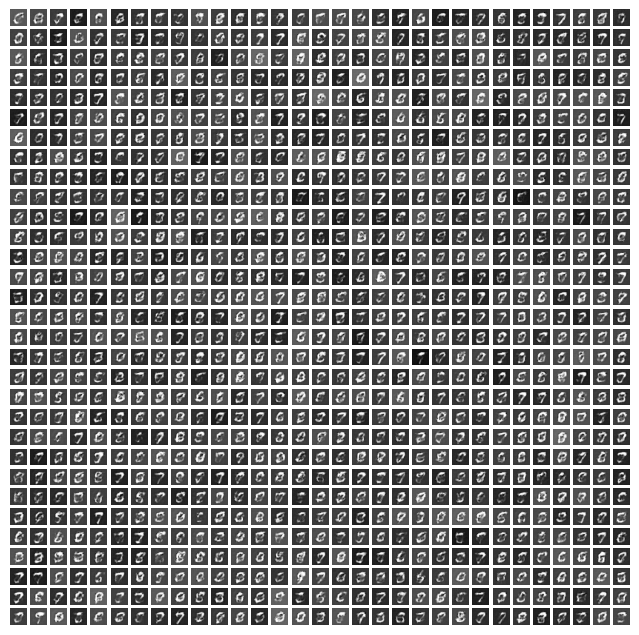

In [66]:
z_prime=private_data_generator(L=10000)
display_fake_images(generator,z_prime,num_images=1000,device=device)